In [1]:
import operator
from typing import List, Literal, Union, NamedTuple, Optional
from pydantic import BaseModel, Field

OperatorType = Literal["+", "-", "*", "/"]
TokenType = Union[float, OperatorType]

## We use these schemas to prompt the LLM to generate equations that evaluate to 24.


class Equation(BaseModel):
    """The formula combining the provided numbers to reach the target of 24."""

    tokens: List[TokenType] = Field(
        description="The stack of tokens and operators in reverse-polish notation. Example: [3, 4, '+', -1, '*'] would evaluate to (3 + 4) * -1 = -7.",
    )

    def compute(self) -> float:
        op_funcs = {
            "+": operator.add,
            "-": operator.sub,
            "*": operator.mul,
            "/": operator.truediv,
        }
        stack = []
        for token in self.tokens:
            if isinstance(token, float):
                stack.append(token)
            else:
                b, a = stack.pop(), stack.pop()
                stack.append(op_funcs[token](a, b))

        return stack[0]


## These objects will represent a single "candidate" (or scored candidate) within our agent's state.
# You can update the candidate object to match your own task.


class Candidate(NamedTuple):
    candidate: Equation
    score: Optional[float] = None
    feedback: Optional[str] = None

    def __str__(self):
        try:
            computed = self.candidate.compute()
        except Exception as e:
            computed = f"Invalid equation: {self.candidate.tokens}; Error: {repr(e)}"

        return f"Equation({self.candidate.tokens}) = {computed} (Reward: {self.score})"


class ScoredCandidate(Candidate):
    candidate: Equation
    feedback: str
    score: float

In [2]:
import requests
import csv

csv_data = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/game-of-24/24.csv"
).content.decode("utf-8")
# Get just the Puzzles column (column index 1)
puzzles = [row[1].strip() for row in csv.reader(csv_data.splitlines()[1:])]

print(f"Example puzzles: {puzzles[:3]}")

Example puzzles: ['1 1 4 6', '1 1 11 11', '1 1 3 8']


In [11]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

class GuessEquations(BaseModel):
    """Submit multiple equations as guesses."""

    reasoning: str = Field(
        description="The reasoning behind the submitted guesses. Explain how you arrived at these equations."
    )

    equations: List[Equation] = Field(
        description="The list of equations to submit as guesses."
    )

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are playing the Game of 24. Using the provide numbers, create an equation that evaluates to 24.\n"
            "Submit exactly {k} guesses for this round.",
        ),
        ("user", "Solve the 24 game for these numbers: {problem}.{candidate}"),
    ],
)#.partial(candidate="")
llm = ChatOpenAI(model="gpt-4.1-nano")

bound_llm = llm.with_structured_output(GuessEquations)
solver = prompt | bound_llm

In [12]:
def compute_score(problem: str, candidate: Candidate) -> ScoredCandidate:
    numbers = list(map(int, problem.split()))
    # Check that the candidate equation uses all 4 numbers exactly once
    used_numbers = [
        token for token in candidate.candidate.tokens if isinstance(token, float)
    ]
    if sorted(used_numbers) != sorted(numbers):
        score = 0
        feedback = "The equation must use all 4 numbers exactly once."
        return ScoredCandidate(
            candidate=candidate.candidate, score=score, feedback=feedback
        )
    try:
        result = candidate.candidate.compute()
        score = 1 / (1 + abs(24 - result))
        feedback = f"Result: {result}"
    except Exception as e:
        score = 0
        feedback = f"Invalid equation. Error: {repr(e)}"
    return ScoredCandidate(
        candidate=candidate.candidate, score=score, feedback=feedback
    )

In [ ]:
import operator
from typing import Optional, Dict, Any, Union, List, Literal
from typing_extensions import Annotated, TypedDict
from langgraph.graph import StateGraph
from langgraph.runtime import Runtime

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Send


def update_candidates(
    existing: Optional[list] = None,
    updates: Optional[Union[list, Literal["clear"]]] = None,
) -> List[str]:
    if existing is None:
        existing = []
    if updates is None:
        return existing
    if updates == "clear":
        return []
    # Concatenate the lists
    return existing + updates


class ToTState(TypedDict):
    problem: str
    candidates: Annotated[List[Candidate], update_candidates]
    scored_candidates: Annotated[List[ScoredCandidate], update_candidates]
    depth: Annotated[int, operator.add]
    # Context parameters added directly to state
    max_depth: int
    threshold: float
    k: int
    beam_size: int

class ExpansionState(ToTState):
    seed: Optional[Candidate]


def expand(state: ExpansionState) -> Dict[str, List[Candidate]]:
    """Generate the next state."""
    print(f'expanding with seed: {state.get("seed")}')
    if not state.get("seed"):
        candidate_str = ""
    else:
        candidate_str = "\n\n" + str(state["seed"])
    try:
        print(f'invoking solver with problem: {state["problem"]}, candidate: {candidate_str}, k: {state["k"]}')
        equation_submission = solver.invoke(
            {
                "problem": state["problem"],
                "candidate": candidate_str,
                "k": state["k"],
            },
        )
    except Exception:
        return {"candidates": []}
    new_candidates = [
        Candidate(candidate=equation) for equation in equation_submission.equations
    ]
    return {"candidates": new_candidates}


def score(state: ToTState) -> Dict[str, Any]:
    """Evaluate the candidate generations."""
    candidates = state["candidates"]
    scored = []
    for candidate in candidates:
        scored.append(compute_score(state["problem"], candidate))
    return {"scored_candidates": scored, "candidates": "clear"}


def prune(state: ToTState) -> Dict[str, Any]:
    scored_candidates = state["scored_candidates"]
    beam_size = state["beam_size"]
    organized = sorted(
        scored_candidates, key=lambda candidate: candidate.score, reverse=True
    )
    pruned = organized[:beam_size]
    return {
        # Update the starting point for the next iteration
        "candidates": pruned,
        # Clear the old memory
        "scored_candidates": "clear",
        # Increment the depth by 1
        "depth": 1,
    }


def should_terminate(state: ToTState) -> Union[Literal["__end__"], Send]:
    if not state["candidates"]:
        return "__end__"
    
    # Check if we have a good solution
    best_candidate = state["candidates"][0]
    solved = hasattr(best_candidate, 'score') and best_candidate.score >= state["threshold"]
    
    if solved or state["depth"] >= state["max_depth"]:
        return "__end__"
    
    return [
        Send("expand", {**state, "seed": candidate})
        for candidate in state["candidates"]
    ]


# Create the graph
builder = StateGraph(state_schema=ToTState)

# Add nodes
builder.add_node(expand)
builder.add_node(score)
builder.add_node(prune)

# Add edges
builder.add_edge("expand", "score")
builder.add_edge("score", "prune")
builder.add_conditional_edges("prune", should_terminate, path_map=["expand", "__end__"])

# Set entry point
builder.add_edge("__start__", "expand")

# Compile the graph
graph = builder.compile(checkpointer=InMemorySaver())

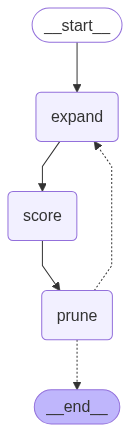

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
for step in graph.stream(
    {
        "problem": puzzles[42],
        "candidates": [],
        "scored_candidates": [],
        "depth": 0,
        "max_depth": 3,
        "threshold": 0.99,  # Stop when we get very close to 24
        "k": 3,  # Generate 3 equations per round
        "beam_size": 2  # Keep top 2 candidates
    },
    config={"configurable": {"thread_id": "test_2"}},
):
    print(step)

expanding with seed: None
invoking solver with problem: 1 5 7 12, candidate: , k: 3
{'expand': {'candidates': [Candidate(candidate=Equation(tokens=[12.0, 1.0, '/', 5.0, 7.0, '*', '+']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[5.0, 7.0, '*', 12.0, '/', '+']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[12.0, 5.0, '-', 7.0, '*', 1.0, '+']), score=None, feedback=None)]}}
{'score': {'scored_candidates': [ScoredCandidate(candidate=Equation(tokens=[12.0, 1.0, '/', 5.0, 7.0, '*', '+']), score=0.041666666666666664, feedback='Result: 47.0'), ScoredCandidate(candidate=Equation(tokens=[5.0, 7.0, '*', 12.0, '/', '+']), score=0, feedback='The equation must use all 4 numbers exactly once.'), ScoredCandidate(candidate=Equation(tokens=[12.0, 5.0, '-', 7.0, '*', 1.0, '+']), score=0.037037037037037035, feedback='Result: 50.0')], 'candidates': 'clear'}}
{'prune': {'candidates': [ScoredCandidate(candidate=Equation(tokens=[12.0, 1.0, '/', 5.0, 7.0, '*', '+']), 

In [24]:
final_state = graph.get_state({"configurable": {"thread_id": "test_1"}})
winning_solution = final_state.values["candidates"][0]
search_depth = final_state.values["depth"]
if winning_solution[1] == 1:
    print(f"Found a winning solution in {search_depth} steps: {winning_solution}")
else:
    print(
        f"Failed to find a winning solution in {search_depth} steps. Best guess: {winning_solution}"
    )

Failed to find a winning solution in 3 steps. Best guess: Equation([12.0, 5.0, '+', 7.0, '-', 1.0, '*']) = 10.0 (Reward: 0.06666666666666667)
